In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from glob import glob

import mne
import mne_nirs

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..')
from preprocessing.scripts import argParser
from preprocessing.src import Plots

In [4]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_clean"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

In [5]:
session_dirs = [d for d in glob(study_dir+"/*/V*/*fNIRS") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [6]:
mne.viz.set_3d_backend('pyvista')
raw_intensities = []

for ses in session_dirs[:1]:
    
#     if os.path.basename(ses)[:participant_num_len] == "50600":
#         pass
#     else:
#         continue
    
    evts = glob(ses + "/*.evt")
    if len(evts) != 2:
        print("There should be 2 evt files. Skipping:", os.path.basename(ses))
        continue
    
    raw_intensities.append(mne.io.read_raw_nirx(ses).load_data())
#     raw_intensities[-1].resample(0.7) # downsample to 0.7 HZ to run faster
    
#     # replace raw_ints annotations with events from custom file. 
#     # read events from file
#     events, event_dict = mne.read_events(join(ses, "new_eve.txt"))
#     annot_from_events = mne.annotations_from_events(
#         events=events,
#         event_desc=event_dict,
#         sfreq=raw_intensities[-1].info['sfreq'],
#         orig_time=raw_intensities[-1].info['meas_date'])
    
#     raw_intensities[-1].set_annotations(annot_from_events)

Using pyvistaqt 3d backend.

Loading /data/perlman/moochie/analysis/CARE/NIRS_data_clean/50891/V0/5089_V0_fNIRS
Reading 0 ... 15111  =      0.000 ...  1934.208 secs...


In [7]:
raw_intensities[0]

<RawNIRX | 5089_V0_fNIRS, 20 x 15112 (1934.2 s), ~2.3 MB, data loaded>

In [8]:
len(raw_intensities[0])

15112

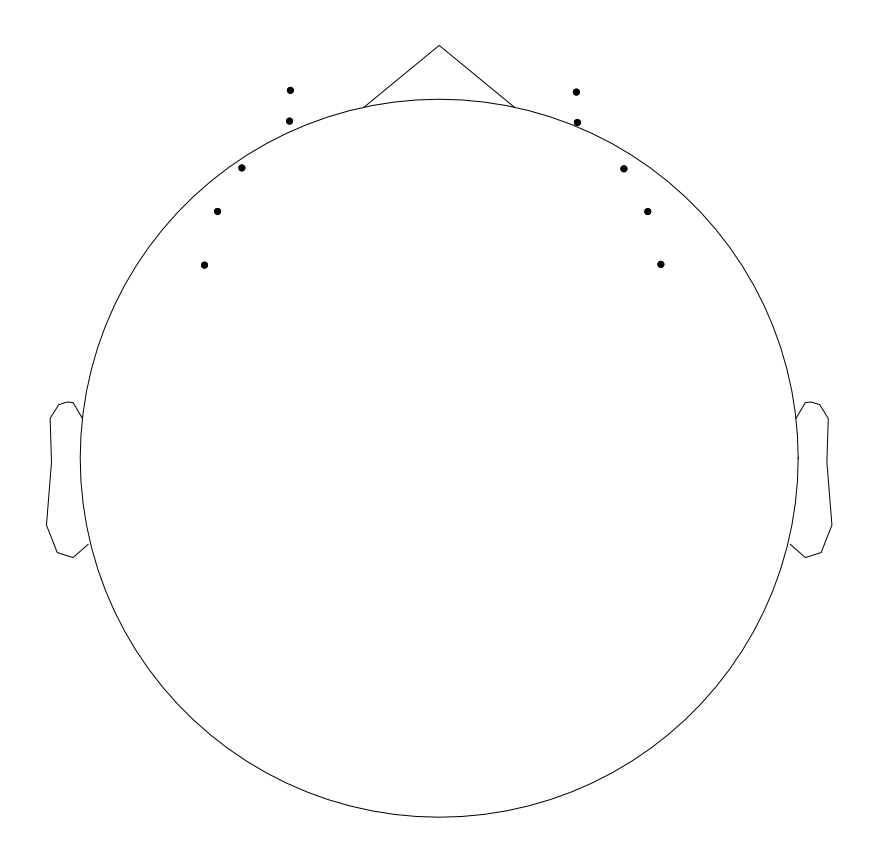

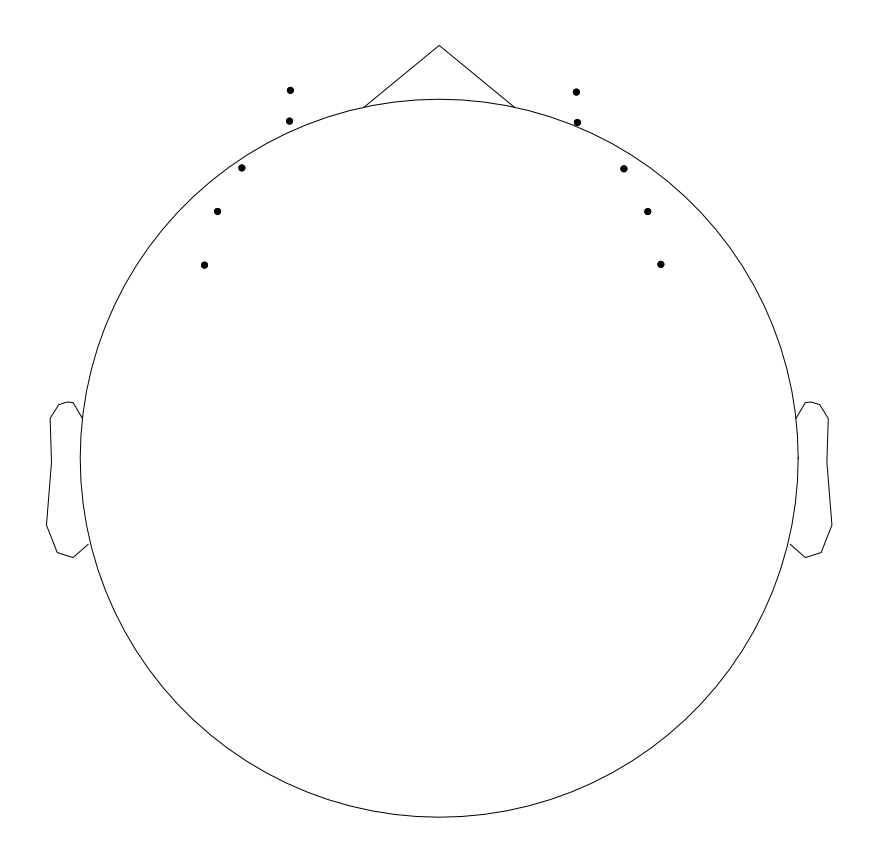

In [9]:
raw_intensities[0].plot_sensors(to_sphere=True) # viz is screwed up lol

In [10]:
def draw_3d_brain():
    fig = mne.viz.create_3d_figure(size=(800, 600), bgcolor='white')

    fig = mne.viz.plot_alignment(
        raw_intensities[0].info,
        show_axes=True,
        subject='fsaverage',
        coord_frame='mri',
        trans='fsaverage',
        surfaces=['brain'],
        fnirs=[
            'channels',
            'pairs',
            'sources',
            'detectors'],
        subjects_dir="/usr/local/pkg/freesurfer/subjects",
        fig=fig)

In [11]:
def label_3d_brain():
    b = mne.viz.Brain(
        'fsaverage',
        'both',
        'pial',
        subjects_dir="/usr/local/pkg/freesurfer/subjects",
        figure=fig,
        units='m',
        alpha=0.2,
        cortex='low_contrast')

    labels = mne.read_labels_from_annot(
        'fsaverage', 
        subjects_dir="/usr/local/pkg/freesurfer/subjects")

    ROIs = [
        'frontalpole-lh',
        'frontalpole-rh',
        'temporalpole-lh',
        'temporalpole-rh'
    ]

    colors = [
        'green',
        'blue',
        'red',
        'orange',
        'yellow'
    ]

    aud_labels = [label for label in labels if label.name in ROIs]
    for i, label in enumerate(aud_labels):
        b.add_label(label, borders=False, color=colors[len(colors)%(i+1)])

In [12]:
# draw_3d_brain()
# label_3d_brain()

In [13]:
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (
    get_long_channels,
    get_short_channels,
    picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

# Clean up annotations before analysis

Next we update the annotations by assigning names to each trigger ID. Then we crop the recording to the section containing our experimental conditions.

In [14]:
sample_rate = raw_intensities[0].info['sfreq']

durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120,
    'Stop Signal': 1}

In [15]:
for raw_ints in raw_intensities:
    print(raw_ints)
    print(raw_ints.annotations)
    
    raw_ints.annotations.rename({
        '1.0': 'Block 1',
        '2.0': 'Block 2',
        '4.0': 'Block 3',
        '128.0': 'Stop Signal'})
    
    raw_ints.annotations.set_durations(durations, verbose=True)

    raw_ints.annotations.delete(raw_ints.annotations.description == 'Stop Signal')

<RawNIRX | 5089_V0_fNIRS, 20 x 15112 (1934.2 s), ~2.3 MB, data loaded>
<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>


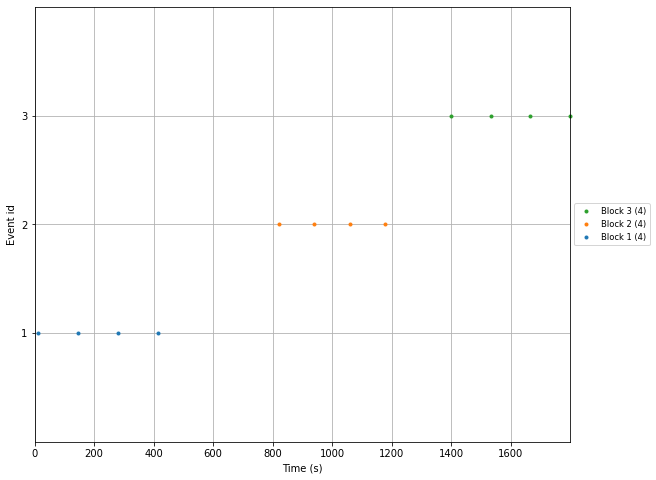

In [16]:
for raw_ints in raw_intensities:
    events, event_dict = mne.events_from_annotations(
        raw_ints,
        verbose=False)

    mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_ints.info['sfreq'])

In [17]:
print(event_dict)

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}


In [18]:
def create_boxcar(raw, event_id=None, stim_dur=1):
    """
    Generate boxcar representation of the experimental paradigm.

    Parameters
    ----------
    raw : instance of Raw
        Haemoglobin data.
    event_id : as specified in MNE
        Information about events.
    stim_dur : Number
        The length of your stimulus.

    Returns
    -------
    s : array
        Returns an array for each annotation label.
    """
    from scipy import signal
    
    events, ids = mne.events_from_annotations(raw, event_id=event_id)
    s = np.zeros((len(raw.times), len(ids)))
    for idx, id in enumerate(ids):
        bc = signal.boxcar(round(raw.info['sfreq'] * stim_dur[id]))
        
        id_idx = [e[2] == idx + 1 for e in events]
        id_evt = events[id_idx]
        event_samples = [e[0] for e in id_evt]
        s[event_samples, idx] = 1.
        s[:, idx] = np.convolve(s[:, idx], bc)[:len(raw.times)]
    return s

Used Annotations descriptions: ['Block 1', 'Block 2', 'Block 3']


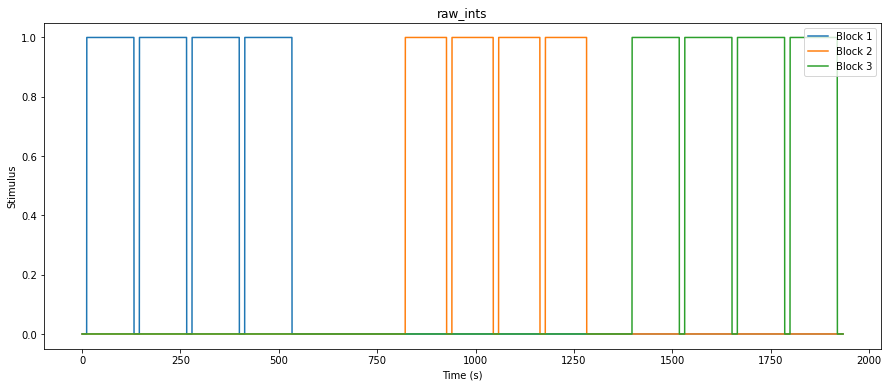

In [19]:
for raw_ints in raw_intensities:
    s = create_boxcar(
        raw_ints,
        stim_dur = durations)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
    plt.plot(raw_ints.times, s, axes=axes)
    plt.legend([
        "Block 1",
        "Block 2",
        "Block 3"],
        loc="upper right")
    plt.xlabel("Time (s)")
    plt.ylabel("Stimulus")
    plt.title("raw_ints")
#     plt.xlim(0, 1800)

In [20]:
raw_ints.info['subject_info']['his_id']

'5089'

# Preprocess NIRS Data

In [21]:
raw_ods = []
for raw_ints in raw_intensities:
    raw_od = mne.preprocessing.nirs.optical_density(raw_ints)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
    
#     short_chs = get_short_channels(raw_haemo)
    long_chs = get_long_channels(raw_haemo)

In [22]:
len(raw_ints)

15112

In [23]:
long_chs

<RawNIRX | 5089_V0_fNIRS, 16 x 15112 (1934.2 s), ~1.9 MB, data loaded>

# Create design matrix

In [24]:
# design_matrix = make_first_level_design_matrix(
#     raw_haemo,
#     hrf_model='spm',
# #     stim_dur=120.0,
#     drift_order=3,
#     drift_model='polynomial')

In [25]:
from nilearn.glm.first_level import make_first_level_design_matrix

In [26]:
raw_ints.annotations[0]

OrderedDict([('onset', 11.648),
             ('duration', 120.0),
             ('description', 'Block 1'),
             ('orig_time',
              datetime.datetime(2022, 1, 18, 15, 15, 34, 54000, tzinfo=datetime.timezone.utc))])

In [27]:
annot = raw_ints.annotations.to_data_frame()

In [28]:
raw_ints.annotations.onset

array([  11.648,  145.536,  279.424,  413.312,  821.376,  940.032,
       1058.688, 1177.472, 1397.888, 1531.776, 1665.664, 1799.552])

In [29]:
annot['onset'] = raw_ints.annotations.onset

In [30]:
annot = annot.rename(columns={"description": "trial_type"})

In [31]:
design_matrix = make_first_level_design_matrix(
    raw_ints.times,
    events=annot,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01,
    drift_order=3)

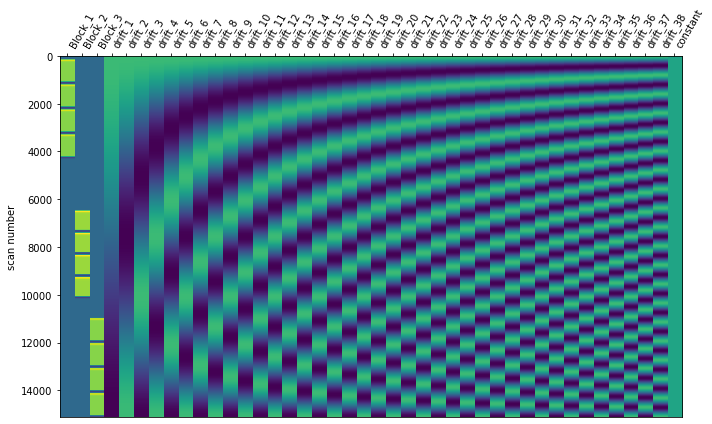

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(design_matrix, ax=ax1)

Opening raw-browser...


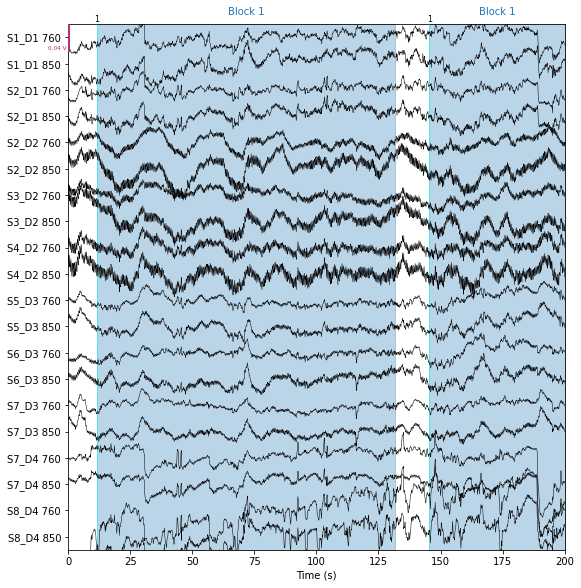

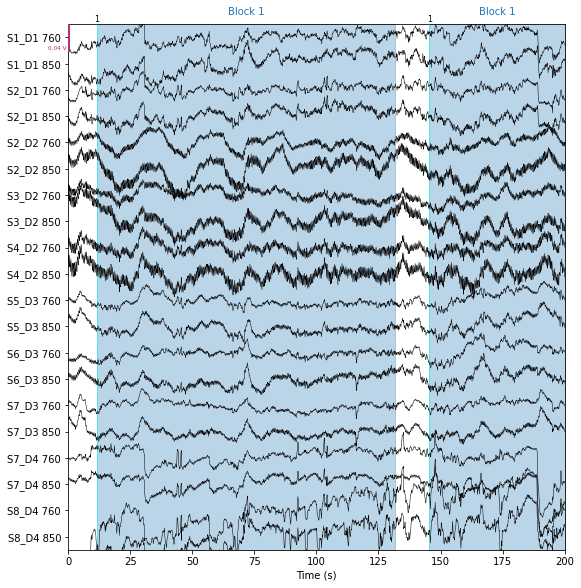

In [36]:
raw_od.plot(events=events, duration=200, show_scrollbars=False, clipping=None)

Bad channels: []


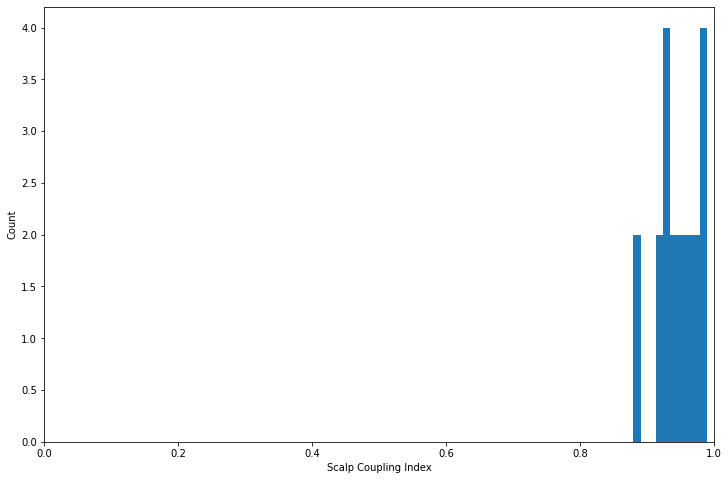

In [49]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

from itertools import compress
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.7))
print("Bad channels:", raw_od.info['bads'])

In [76]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

Opening raw-browser...


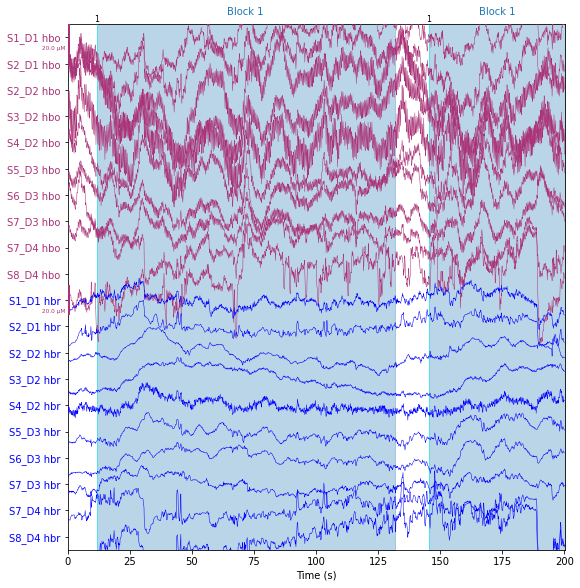

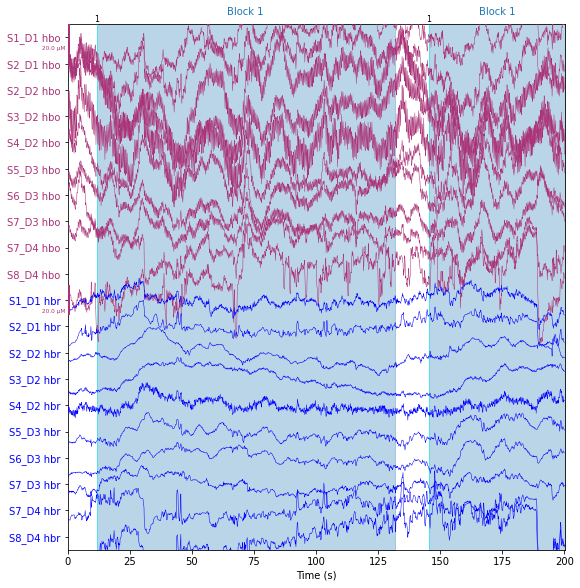

In [77]:
raw_haemo.plot(events=events, duration=200, show_scrollbars=False, clipping=None)

Used Annotations descriptions: ['Block 1', 'Block 2', 'Block 3']


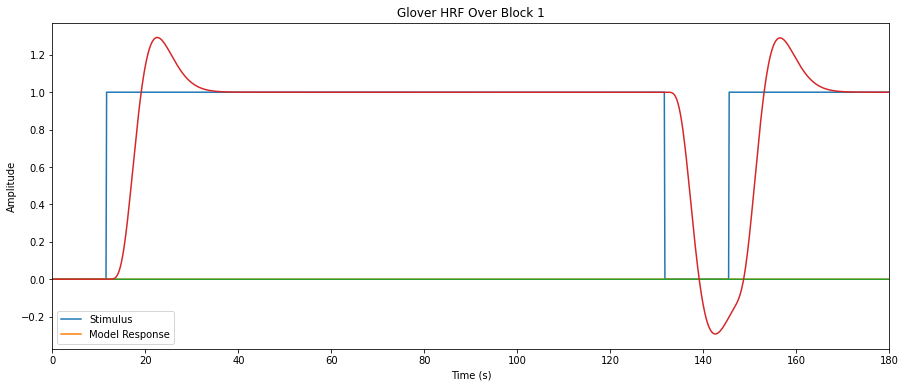

In [59]:
for raw_ints in raw_intensities:
    s = create_boxcar(
        raw_ints,
        stim_dur = durations)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
    plt.plot(raw_ints.times, s, axes=axes)

    plt.plot(design_matrix['Block_1'])
    
#     plt.legend([
#         "Block 1",
#         "Block 2",
#         "Block 3"],
#         loc="upper right")
    plt.legend(["Stimulus", "Model Response"])
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Glover HRF Over Block 1")
    
    plt.xlim(0, 180)

In [60]:
for raw in raw_intensities:
    peak = mne_nirs.preprocessing.peak_power(raw_od)
    print(peak)

(<RawNIRX | 5089_V0_fNIRS, 20 x 15112 (1934.2 s), ~2.3 MB, data loaded>, array([[0.16735886, 0.27852746, 0.25700606, ..., 0.24328252, 0.13021933,
        0.16865156],
       [0.16735886, 0.27852746, 0.25700606, ..., 0.24328252, 0.13021933,
        0.16865156],
       [0.16533356, 0.29880549, 0.4537461 , ..., 0.98085504, 0.26084151,
        0.62965626],
       ...,
       [0.23348557, 0.25042148, 0.22741238, ..., 0.36730956, 0.2033965 ,
        0.32519937],
       [0.2779144 , 0.11305656, 0.1915792 , ..., 0.39581802, 0.38876251,
        0.35629889],
       [0.2779144 , 0.11305656, 0.1915792 , ..., 0.39581802, 0.38876251,
        0.35629889]]), [(0.0, 10.112), (10.112, 20.224), (20.224, 30.336), (30.336, 40.448), (40.448, 50.56), (50.56, 60.672), (60.672, 70.784), (70.784, 80.896), (80.896, 91.008), (91.008, 101.12), (101.12, 111.232), (111.232, 121.344), (121.344, 131.456), (131.456, 141.568), (141.568, 151.68), (151.68, 161.792), (161.792, 171.904), (171.904, 182.016), (182.016, 192.12

Effective window size : 262.144 (s)


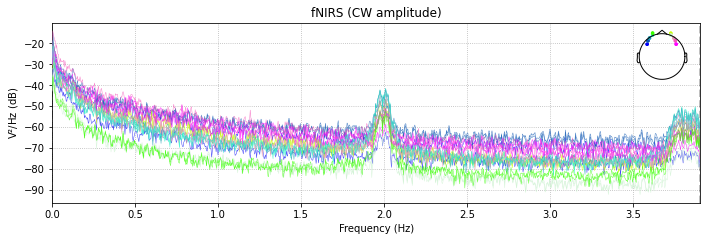

In [61]:
for raw in raw_intensities:
    raw.plot_psd()

Effective window size : 262.144 (s)
Effective window size : 262.144 (s)


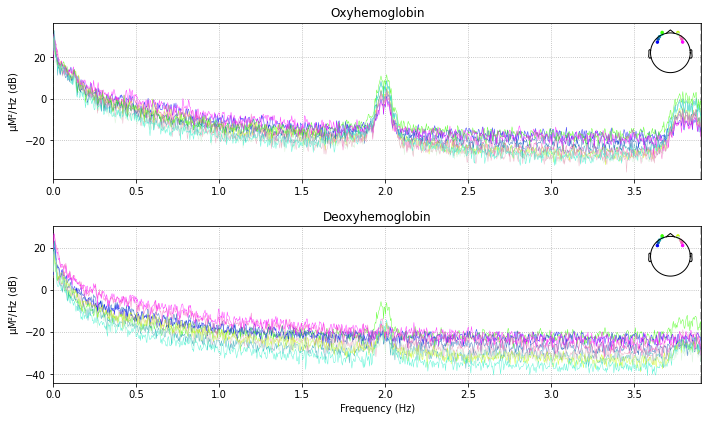

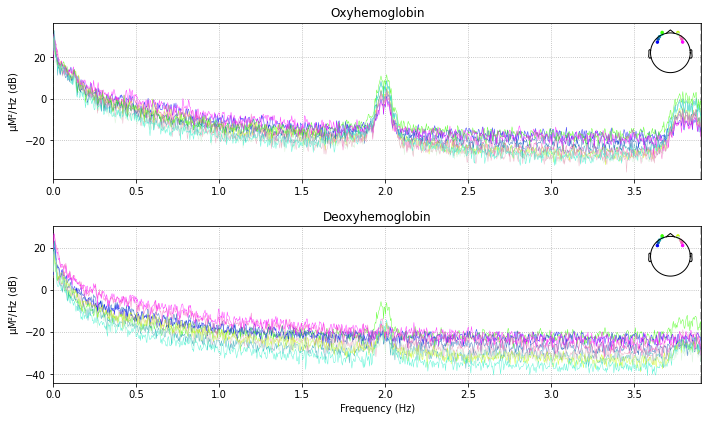

In [62]:
raw_haemo.plot_psd()

Effective window size : 262.144 (s)


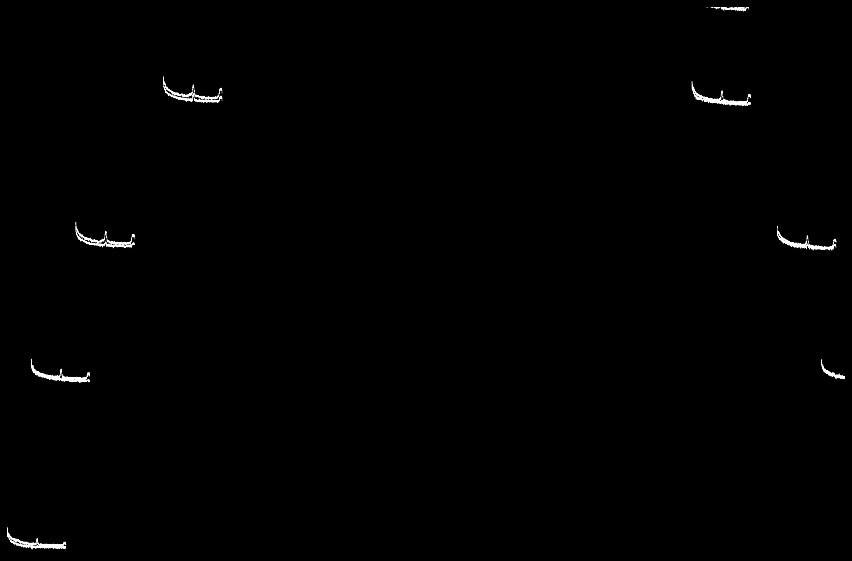

In [63]:
for raw in raw_intensities:
    raw_haemo.plot_psd_topo()

# Fit GLM to Subset of data and estimate response for each experimental condition

In [179]:
data_subset = raw_haemo.copy().pick(picks=range(2))

In [180]:
glm_est = run_glm(data_subset, design_matrix, noise_model='ar4')

In [181]:
glm_est

GLM Results for 2 channels

In [182]:
glm_est.ch_names

['S1_D1 hbo', 'S1_D1 hbr']

In [183]:
glm_est.copy().pick('hbo')

GLM Results for 1 channels

In [185]:
glm_est.data['S1_D1 hbo'].model.rho

array([ 0.96435698, -0.08090524,  0.0668896 ,  0.03997772])

Text(0, 0.5, 'Delta Mol')

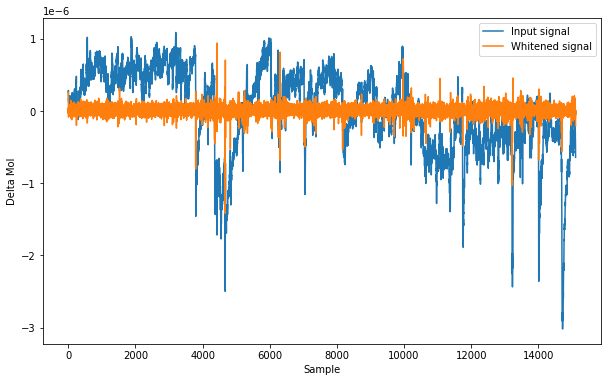

In [186]:
plt.plot(glm_est.data['S1_D1 hbo'].Y)
plt.plot(glm_est.data['S1_D1 hbo'].whitened_Y)

plt.legend(["Input signal", "Whitened signal"])

plt.xlabel("Sample")
plt.ylabel("Delta Mol")

In [187]:
glm_est.to_dataframe()

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,Block_1_Start,7.0,4.187141e-15,0.480678,8.567755e-08,0.744742,6.380768e-08,1,1,hbo,False,S1_D1 hbo
1,Block_2_Start,7.0,4.187141e-15,0.145418,8.787840e-08,1.638068,1.439508e-07,1,1,hbo,False,S1_D1 hbo
2,Block_3_Start,7.0,4.187141e-15,0.395273,9.337474e-08,0.905549,8.455541e-08,1,1,hbo,False,S1_D1 hbo
3,constant,7.0,4.187141e-15,0.333333,6.269736e-08,-1.039054,-6.514596e-08,1,1,hbo,False,S1_D1 hbo
4,drift_1,7.0,4.187141e-15,0.001296,2.074049e-07,-5.169154,-1.072108e-06,1,1,hbo,True,S1_D1 hbo
5,drift_2,7.0,4.187141e-15,0.229432,6.487285e-07,-1.316625,-8.541318e-07,1,1,hbo,False,S1_D1 hbo
6,drift_3,7.0,4.187141e-15,0.657649,2.342262e-06,0.462656,1.083662e-06,1,1,hbo,False,S1_D1 hbo
7,Block_1_Start,7.0,5.700375e-16,0.077546,3.024489e-08,2.067122,6.251988e-08,1,1,hbr,False,S1_D1 hbr
8,Block_2_Start,7.0,5.700375e-16,0.299201,3.130494e-08,1.121165,3.509800e-08,1,1,hbr,False,S1_D1 hbr
9,Block_3_Start,7.0,5.700375e-16,0.429855,3.446035e-08,0.837727,2.886837e-08,1,1,hbr,False,S1_D1 hbr


<AxesSubplot:xlabel='Condition', ylabel='Theta'>

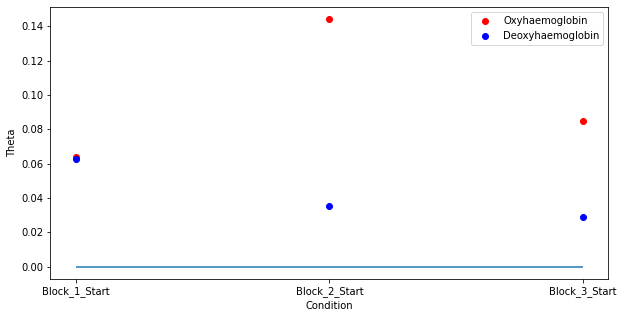

In [188]:
glm_est.scatter()

# Run on entire dataset (all channels)

In [189]:
glm_est = run_glm(raw_haemo, design_matrix)

In [190]:
glm_est

GLM Results for 20 channels

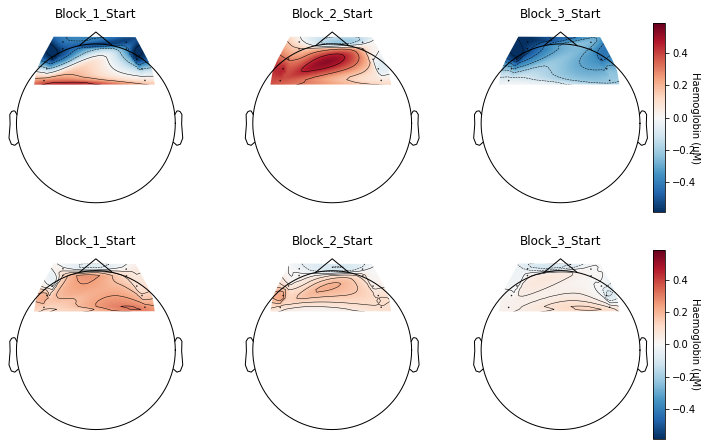

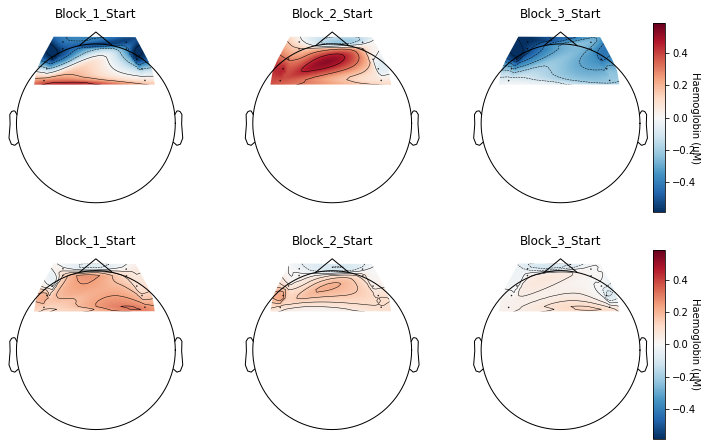

In [192]:
glm_est.plot_topo(conditions=["Control", "Block_1_Start", "Block_2_Start", "Block_3_Start"])

In [167]:
_, scores, times = scalp_coupling_index_windowed(raw_od, time_window=60)
plot_timechannel_quality_metric(raw_od, scores, times, threshold=0.7,
    title="Scalp Coupling Index Quality Evaluation")

NameError: name 'scalp_coupling_index_windowed' is not defined

In [65]:
raw_od, scores, times = peak_power(raw_od, time_window=10)
plot_timechannel_quality_metric(raw_od, scores, times, threshold=0.1,
    title="Peak Power Quality Evaluation")

NameError: name 'peak_power' is not defined